In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, MaxPooling1D, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, AveragePooling1D, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import Constant
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.layers import Dropout
from tensorflow.keras.backend import clear_session
import re
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
import spacy

print('libs loaded')

libs loaded


In [49]:
WORD_EMBEDDING_SIZE = 200
TWEET_MAX_LENGTH = 150

glove_file_path = 'glove.twitter.27B.200d.txt'

db1_path = 'obama.csv'
db2_path = 'romney.csv'

# db1 = pd.read_csv(db1_path, encoding='macroman')
db2 = pd.read_csv(db2_path, encoding='macroman')

print(db1.columns)
print(db2.columns)

# db = pd.concat([db1, db2], axis=0)
# db = db1
db = pd.read_csv(db2_path, encoding='macroman')

print('db shape:', db.shape)
print()

db.drop(columns = ['date', 'time'], inplace = True)
db['Class'] = pd.to_numeric(db['Class'], errors='coerce')
db = db.dropna()

db['Class'] = db['Class'].astype(int)
db.rename(columns = {'Anootated tweet':'tweet', 'Class': 'class'}, inplace = True)

#dropping class 2
db = db[db['class'] != 2]

db.reset_index(drop=True, inplace=True)

print('db shape:', db.shape)
print()
print(db.dtypes)
print(db.isnull().values.any())

db.head()
# testdb = pd.read_csv('/content/drive/MyDrive/CS 583 P2/sample-testdata.csv', header = None)

# print(testdb[1])

Index(['date', 'time', 'Anootated tweet', 'Class'], dtype='object')
Index(['date', 'time', 'Anootated tweet', 'Class'], dtype='object')
db shape: (7200, 4)

db shape: (5648, 2)

tweet    object
class     int32
dtype: object
False


,tweet,class
0,Insidious!<e>Mitt Romney</e>'s Bain Helped Phi...,-1
1,.@WardBrenda @shortwave8669 @allanbourdius you...,-1
2,<e>Mitt Romney</e> still doesn't <a>believe</a...,-1
3,<e>Romney</e>'s <a>tax plan</a> deserves a 2nd...,-1
4,Hope <e>Romney</e> debate prepped w/ the same ...,1


<Axes: xlabel='class', ylabel='count'>

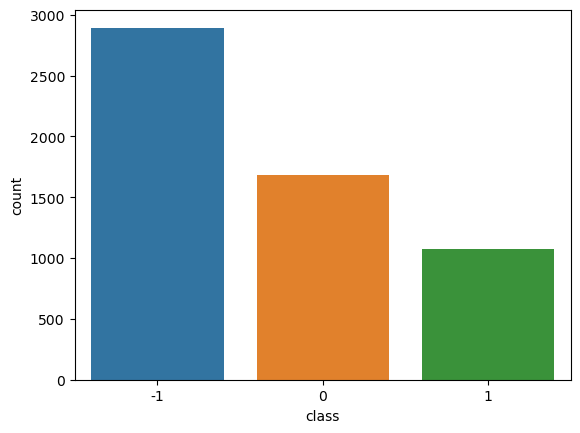

In [50]:
sns.countplot(x='class', data=db)

In [16]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# ----------------------------------------------------------------


def tokenize_tweet(tweet):
  return word_tokenize(tweet)

def preprocess_tweet(tweet):
    # Convert to lowercase
    tweet = tweet.lower()

    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)

    # Remove HTML tags
    tweet = re.sub('<.*?>', '', tweet)

    # Remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Tokenize tweet
    tokens = word_tokenize(tweet)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into a string
    processed_tweet = ' '.join(tokens)

    return processed_tweet

def new_preprocess_tweet(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')

    tweet = tweet.lower()
    
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)
        
    # Remove HTML tags
    tweet = re.sub('<.*?>', '', tweet)
        
    tokens = tweet.split()
    
     # Remove URLs, user mentions, numbers, and special characters
    tokens = [token for token in tokens if not token.startswith('@') and not token.startswith('http')]
    tokens = [token for token in tokens if not token.isdigit()]
    
    # Remove tokens with special characters except punctuation
    pattern = r'[^a-zA-Z0-9\s{}]'.format(re.escape(string.punctuation))
    
    tokens = [re.sub(pattern, '', token) for token in tokens]
    
    tweet = ' '.join(tokens)
        
    # Tokenize tweet
    tokens = word_tokenize(tweet)
        
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]

    # Replace multiple same characters at the end of a word with only two of those characters
    tokens = [re.sub(r'(.)\1+$', r'\1\1', token) for token in tokens]
        
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
        
    # Lemmatize tokens
    # lemmatizer = WordNetLemmatizer()
    # # temp = [lemmatizer.lemmatize(token) for token in tokens]
    # tokens = [stemmer.stem(token) for token in tokens]
        
    # Join tokens back into a string
    processed_tweet = ' '.join(tokens)

    return processed_tweet

def new_preprocess_tweet_v2(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')

    tweet = tweet.lower()
    
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)
        
    # Remove HTML tags
    tweet = re.sub('<.*?>', '', tweet)
        
    tknzr = TweetTokenizer()
    tokens = tknzr.tokenize(tweet)
    
     # Remove URLs, user mentions, numbers, and special characters
    tokens = [token for token in tokens if not token.startswith('@') and not token.startswith('http')]
    tokens = [token for token in tokens if not token.isdigit()]
    
    # Remove tokens with special characters except punctuation
    pattern = r'[^a-zA-Z0-9\s{}]'.format(re.escape(string.punctuation))
    
    tokens = [re.sub(pattern, '', token) for token in tokens]
    
    tweet = ' '.join(tokens)
        
    # Tokenize tweet
    # tokens = word_tokenize(tweet)
    nlp = spacy.load("en_core_web_lg")

    doc = nlp(tweet)
    tokens = [token.text for token in doc]
        
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
        
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
        
    # Lemmatize tokens
    # lemmatizer = WordNetLemmatizer()
    # # temp = [lemmatizer.lemmatize(token) for token in tokens]
    # tokens = [stemmer.stem(token) for token in tokens]
        
    # Join tokens back into a string
    processed_tweet = ' '.join(tokens)

    return processed_tweet

def preprocess_tweets(df):
    df['tweet'] = df['tweet'].apply(new_preprocess_tweet)
    return df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tanuj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanuj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tanuj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [51]:
print('before:', db['tweet'][20])
print('before:', db['tweet'][999])
print('before:', db['tweet'][11])
print()

db = preprocess_tweets(db)

#dropping class 2
db = db[db['class'] != 2]

db['class'] = db['class'].replace({-1: 0, 0: 1, 1: 2})

print('after:', db['tweet'][20])
print('after:', db['tweet'][999])
print('after:', db['tweet'][11])

before: Hope the <a>debate</a> goes as well for <e>Romney </e>tonight as it did the first time around. But, with hair like that, how could it not?? @Mollaysia
before: <e>Romney</e> will "harvest" all of us. (@YouTube http://t.co/NqG7JM69)
before: If women that the Polls show are truly voting for <e>Romney</e>? Then I don't want to know how they truly take care of their household's.

after: hope debate goes well romney tonight first time around hair like could
after: romney `` harvest '' us youtube
after: women polls show truly voting romney n't want know truly take care household 's


In [73]:
tweet = 'yayyyy'

print(tweet)
print(preprocess_tweet(tweet))

print(new_preprocess_tweet(tweet))

print(new_preprocess_tweet_v2(tweet))

yayyyy
yayyyy
yayy
yayyyy


In [268]:
tknzr = TweetTokenizer()
# text = "This is a cooool #dummysmiley: :-) :-P <3 and some arrows < > -> <--"
text = db['tweet'][20]
tokens = tknzr.tokenize(text)
print(tokens)

tokens = nltk.word_tokenize(text)
print(tokens)

nlp = spacy.load("en_core_web_sm")

doc = nlp(text)
tokens = [token.text for token in doc]
print(tokens)

['debate', '#', '2', 'tonight', '!', 'I', 'hope', '<e>', 'Obama', '</e>', 'brings', 'a', 'lot', 'of', 'energy', 'tonight', '.', 'This', 'debate', 'is', 'crucial', '#obama2012']
['debate', '#', '2', 'tonight', '!', 'I', 'hope', '<', 'e', '>', 'Obama', '<', '/e', '>', 'brings', 'a', 'lot', 'of', 'energy', 'tonight', '.', 'This', 'debate', 'is', 'crucial', '#', 'obama2012']
['debate', '#', '2', 'tonight', '!', 'I', 'hope', '<', 'e', '>', 'Obama</e', '>', 'brings', 'a', 'lot', 'of', 'energy', 'tonight', '.', 'This', 'debate', 'is', 'crucial', '#', 'obama2012']


# Word Embedding

In [6]:
embeddings_dictionary = dict()
glove_file = open(glove_file_path, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.array(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

print('embeddings loaded')

embeddings loaded


In [52]:
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

temp = set()
temp2 = set()

def create_embedding_matrix(embeddings_dictionary, tokenizer):
    vocab_size = len(tokenizer.word_index) + 1

    embedding_matrix = np.zeros((vocab_size, WORD_EMBEDDING_SIZE))

    for word, i in tokenizer.word_index.items():
        if word in embeddings_dictionary:
            embedding_matrix[i] = embeddings_dictionary[word]
        else:
            temp.add(word)

    return embedding_matrix

def create_embedding_matrix_using_map(embeddings_dictionary, unique_tokens):
    vocab_size = len(unique_tokens)

    embedding_matrix = np.zeros((vocab_size, WORD_EMBEDDING_SIZE))

    for word, i in unique_tokens.items():
        if word in embeddings_dictionary:
            embedding_matrix[i] = embeddings_dictionary[word]
        else:
            temp2.add(word)

    return embedding_matrix

def get_token_map(tweets):
    unique_tokens = set()

    for tweet in tweets:
        tokens = word_tokenize(tweet.lower())
        unique_tokens.update(tokens)

    token_map = {token: index for index, token in enumerate(unique_tokens)}

    return token_map


word_tokenizer_keras = Tokenizer()
word_tokenizer_keras.fit_on_texts(db['tweet'])

nltk_token_map = get_token_map(db['tweet'])

# Create the embedding matrix
glovee_embedding_matrix = create_embedding_matrix(embeddings_dictionary, word_tokenizer_keras)
glovee_embedding_matrix_2 = create_embedding_matrix_using_map(embeddings_dictionary, nltk_token_map)

sentences = [word_tokenize(tweet) for tweet in db['tweet']]
w2v_model = Word2Vec(sentences=sentences, vector_size = WORD_EMBEDDING_SIZE,
                     window=10,
                     min_count=1,
                     workers=4)

# Create the embedding matrix for Word2Vec
w2v_embedding_matrix = create_embedding_matrix(w2v_model.wv, word_tokenizer_keras)
w2v_embedding_matrix_2 = create_embedding_matrix_using_map(w2v_model.wv, nltk_token_map)

In [19]:
def get_token_mapftw(tweets):
    tknzr = TweetTokenizer()
    unique_tokens = set()

    for tweet in tweets:
        tokens = tknzr.tokenize(tweet.lower())
        unique_tokens.update(tokens)

    token_map = {token: index for index, token in enumerate(unique_tokens)}

    return token_map

def get_token_map_spacy(nlp, tweets):
    unique_tokens = set()

    for tweet in tweets:
        tokens = [token.text for token in nlp(tweet.lower())]
        unique_tokens.update(tokens)

    token_map = {token: index for index, token in enumerate(unique_tokens)}

    return token_map

# Load the Spacy model
nlp = spacy.load('en_core_web_lg')

# Get unique tokens using Spacy for tokenization
spacy_token_map = get_token_map_spacy(nlp, db['tweet'])

# Create the embedding matrix
# Get unique tokens
nltkftw_token_map = get_token_mapftw(db['tweet'])

# Create the embedding matrix
glovee_embedding_matrix_spacy = create_embedding_matrix_using_map(embeddings_dictionary, spacy_token_map)
glovee_embedding_matrix_nltkftw = create_embedding_matrix_using_map(embeddings_dictionary, nltkftw_token_map)

print('dne')

dne


In [9]:
# a little analysis on difference in words with no embedding in preloaded vs trained embedders and tokenizers
print(len(temp), len(temp2))

temp = list(temp)
temp2 = list(temp2)

# print(nltk_token_map)

# for i in range(100):
#   print(i, temp[i], temp2[i])

2623 3457


In [129]:
new_preprocess_tweet('intellectual')

'intellectual'

In [ ]:
embeddings_dictionary[":->"]

In [53]:
def get_tokenized_tweets(tokenizer, text_data):
    return tokenizer.texts_to_sequences(text_data)

def get_nltk_tokenized(nltk_token_map, tweets):
    tokens = [tokenize_tweet(tw) for tw in tweets]
    tokens = [[nltk_token_map[w] for w in tw] for tw in tokens]

    return tokens

def tweet_to_emb(tokenized_tweet, embedding_matrix):
    embeddings = []

    for token in tokenized_tweet:
        # if token in model: # ignore the unknown for now
      embeddings.append(embedding_matrix[token])

    # padded_embeddings = pad_sequences([embeddings], maxlen = TWEET_MAX_LENGTH, dtype = 'float32', padding = 'post')[0]

    # print(len(padded_embeddings), len(padded_embeddings[0]))

    return np.array(embeddings)

def get_emb_tweets(tokenized_tweets, embedding_matrix):
    ret = [tweet_to_emb(tw, embedding_matrix) for tw in tokenized_tweets]
    # print(ret)
    return np.array(ret)

# embedded_tweets = get_emb_tweets(glovee_embedding_matrix, word_tokenizer_keras)

# print(len(db['tweet']))
# print(embedded_tweets.shape)


#-------------tokenizing--------------------
tokenized_tweets_keras = get_tokenized_tweets(word_tokenizer_keras, db['tweet'])

tokenized_tweets_nltk = get_nltk_tokenized(nltk_token_map, db['tweet'])


tokenized_tweets_keras = pad_sequences(tokenized_tweets_keras, maxlen = TWEET_MAX_LENGTH, padding = 'post')

tokenized_tweets_nltk = pad_sequences(tokenized_tweets_nltk, maxlen = TWEET_MAX_LENGTH, padding = 'post')

# print(tokenized_tweets_keras[0][0])

#-------------embedding----------------------
embedded_tweets_nltk_glovee = get_emb_tweets(tokenized_tweets_nltk, glovee_embedding_matrix_2)
embedded_tweets_nltk_w2v = get_emb_tweets(tokenized_tweets_nltk, w2v_embedding_matrix_2)

embedded_tweets_keras_glovee = get_emb_tweets(tokenized_tweets_keras, glovee_embedding_matrix)
embedded_tweets_keras_w2v = get_emb_tweets(tokenized_tweets_keras, w2v_embedding_matrix)

#-------------padding-------------------------
tokenized_padded_tweets = pad_sequences(tokenized_tweets_nltk, maxlen = TWEET_MAX_LENGTH, padding='post')

In [21]:
def get_nltk_tokenizedftw(nltkftw_token_map, tweets):
    tknzr = TweetTokenizer()
    tokens = [tknzr.tokenize(tw) for tw in tweets]
    tokens = [[nltkftw_token_map[w] for w in tw] for tw in tokens]

    return tokens

def get_spacy_tokenized(nlp, token_map, tweets):
    tokens = [[token.text for token in nlp(tw)] for tw in tweets]
    tokens = [[token_map.get(w, 0) for w in tw] for tw in tokens]

    return tokens

tokenized_tweets_spacy = get_spacy_tokenized(nlp, spacy_token_map, db['tweet'])
tokenized_tweets_nltkftw = get_nltk_tokenizedftw(nltkftw_token_map, db['tweet'])

tokenized_tweets_spacy = pad_sequences(tokenized_tweets_spacy, maxlen = TWEET_MAX_LENGTH, padding = 'post')
tokenized_tweets_nltkftw = pad_sequences(tokenized_tweets_nltkftw, maxlen = TWEET_MAX_LENGTH, padding = 'post')

embedded_tweets_spacy_glovee = get_emb_tweets(tokenized_tweets_spacy, glovee_embedding_matrix_spacy)
embedded_tweets_nltkftw_glovee = get_emb_tweets(tokenized_tweets_nltkftw, glovee_embedding_matrix_nltkftw)
print('dne')

dne


In [54]:
#-------------Train Test Split-----------------
X_train, X_test, y_train, y_test = train_test_split(embedded_tweets_keras_glovee, np.array(db['class']), test_size = 0.15)

In [23]:
print("Training set shape:", len(X_train), ' ', len(X_train[0]))
print(len(embedded_tweets_nltk_glovee), ' ', len(embedded_tweets_nltk_glovee[0]), ' ', len(embedded_tweets_nltk_glovee[0][0]))
# print(X_train[0])
# print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: 4780   150
5624   150   200


# Training

In [24]:
def evaluate_model(model, X_test, y_test):
    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test, y_test)

    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")

    # Predict the labels for the test set
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

In [55]:
# vocab_size = len(word_tokenizer_keras.word_index) + 1
# vocab_size = len(nltk_token_map)

# X = pad_sequences(tokenized_tweets_nltk, maxlen = TWEET_MAX_LENGTH, padding='post')

# print(X.shape)

# X_train, X_test, y_train, y_test = train_test_split(X, np.array(db['class']), test_size = 0.15)
clear_session()

model_ff_nn = Sequential([
    # Embedding(vocab_size, WORD_EMBEDDING_SIZE),
    Flatten(),
    Dense(128, activation='relu'),  # Dense layer with 64 units and ReLU activation
    Dropout(0.3),
    Dense(3, activation='softmax')  # Output layer with 3 units for classification
])


#--------------compile model-----------------
model_ff_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#-----------------Train-----------------------
model_ff_nn.fit(X_train, y_train, epochs = 3, validation_split = 0.05)

#-----------------Test-----------------------
evaluate_model(model_ff_nn, X_test, y_test)

Epoch 1/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.5287 - loss: 0.9974 - val_accuracy: 0.5625 - val_loss: 0.9249
Epoch 2/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6577 - loss: 0.7872 - val_accuracy: 0.5750 - val_loss: 0.9246
Epoch 3/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7511 - loss: 0.6197 - val_accuracy: 0.5375 - val_loss: 1.0092
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5524 - loss: 1.0250
Test Loss: 0.9853312373161316
Test Accuracy: 0.5683962106704712
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
F1 Score: 0.5464
Precision: 0.5480
Recall: 0.5684


In [58]:
# Define the learning rate
learning_rate = 0.002  # Example learning rate, you can adjust this value

# Compile the model with the Adam optimizer and the specified learning rate
# model_conv_nn = Sequential([
#     Conv1D(100, 3, activation='relu'),
#     AveragePooling1D(2),
#     Conv1D(100, 4, activation='relu'),
#     AveragePooling1D(2),
#     Conv1D(100, 5, activation='relu'),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(3, activation='softmax')
# ])

model_conv_nn = Sequential([
    # Embedding(vocab_size, 150),
    Conv1D(100, 5, activation='relu'),
    AveragePooling1D(2),
    Conv1D(100, 6, activation='relu'),
    # AveragePooling1D(2),
    # Conv1D(200, 7, activation='relu'),
    AveragePooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.6),
    Dense(3, activation='softmax')
])

model_conv_nn.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_conv_nn.fit(X_train, y_train, epochs = 5, batch_size = 20, validation_split = 0.05)

#-----------------Test-----------------------
evaluate_model(model_conv_nn, X_test, y_test)

Epoch 1/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5055 - loss: 1.0178 - val_accuracy: 0.5792 - val_loss: 0.9279
Epoch 2/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6014 - loss: 0.8895 - val_accuracy: 0.5250 - val_loss: 0.9844
Epoch 3/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6517 - loss: 0.7884 - val_accuracy: 0.6042 - val_loss: 1.0085
Epoch 4/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7298 - loss: 0.6318 - val_accuracy: 0.5917 - val_loss: 1.0567
Epoch 5/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8135 - loss: 0.4489 - val_accuracy: 0.5333 - val_loss: 1.3291
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5001 - loss: 1.3411
Test Loss: 1.3193691968917847
Test Accuracy: 0.5117924809455872
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
F1 Score: 0.5214
Precision: 0.5514
Recall: 0.5118


In [ ]:
# import matplotlib.pyplot as plt

# def train_and_plot(X_train, X_test, y_train, y_test, epochs=10):
#     history = []

#     model_conv_nn_1 = Sequential([
#         Conv1D(100, 3, activation='relu'),
#         AveragePooling1D(2),
#         Conv1D(100, 4, activation='relu'),
#         AveragePooling1D(2),
#         Conv1D(100, 5, activation='relu'),
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dropout(0.5),
#         Dense(3, activation='softmax')
#     ])

#     model_ff_nn_1 = Sequential([
#         Flatten(input_shape=(TWEET_MAX_LENGTH, WORD_EMBEDDING_SIZE)),  # Flatten the input
#         Dense(64, activation='relu'),  # Dense layer with 64 units and ReLU activation
#         Dropout(0.3),
#         Dense(3, activation='softmax')  # Output layer with 3 units for classification
#     ])

#     models = [
#         ['model_ff_nn_1', model_ff_nn_1],
#         ['model_conv_nn_1', model_conv_nn_1]
#     ]

#     for [name, model] in models:
#         model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#         print(f"Training model: {name}")

#         hist = model.fit(X_train, y_train, epochs = epochs, validation_split = 0.1, verbose = 0)

#         history.append(hist)

#         loss, accuracy = model.evaluate(X_test, y_test)

#         print(f"Test Loss for {name}: {loss}")
#         print(f"Test Accuracy for {name}: {accuracy}")

#     plt.figure(figsize=(10, 6))

#     for i, hist in enumerate(history):
#         plt.plot(hist.history['val_accuracy'], label = models[i][0])

#     plt.title('Validation Accuracy vs. Epochs')
#     plt.xlabel('Epochs')
#     plt.ylabel('Validation Accuracy')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     clear_session()


# embeddings = {
#     'embedded_tweets_nltk_glovee': embedded_tweets_nltk_glovee,
#     'embedded_tweets_nltk_w2v': embedded_tweets_nltk_w2v,
#     'embedded_tweets_keras_w2v': embedded_tweets_keras_w2v,
#     'embedded_tweets_keras_glovee': embedded_tweets_keras_glovee
# }

# # Train and plot the models
# for name, embedding in embeddings.items():
#     print('for:', name)
#     X_train, X_test, y_train, y_test = train_test_split(embedding, np.array(db['class']), test_size=0.15)

#     train_and_plot(X_train, X_test, y_train, y_test)

In [56]:
model_lstm = Sequential([
    LSTM(500, dropout = 0.2, recurrent_dropout=0.2),  # LSTM layer with 64 units,
    # Dense(64, activation = 'relu'),
    # Dropout(0.3),
    Dense(3, activation = 'softmax')
])

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_lstm.fit(X_train, y_train, epochs=10, batch_size=20, validation_split=0.1)

# Evaluate the model on the test set
#-----------------Test-----------------------
evaluate_model(model_lstm, X_test, y_test)

Epoch 1/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 108s 489ms/step - accuracy: 0.5172 - loss: 1.0906 - val_accuracy: 0.5333 - val_loss: 1.0046
Epoch 2/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 99s 459ms/step - accuracy: 0.5147 - loss: 1.0175 - val_accuracy: 0.5333 - val_loss: 1.0051
Epoch 3/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 103s 478ms/step - accuracy: 0.5091 - loss: 1.0240 - val_accuracy: 0.5333 - val_loss: 1.0063
Epoch 4/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 103s 475ms/step - accuracy: 0.5126 - loss: 1.0193 - val_accuracy: 0.5333 - val_loss: 1.0075
Epoch 5/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 104s 480ms/step - accuracy: 0.5016 - loss: 1.0318 - val_accuracy: 0.5333 - val_loss: 1.0060
Epoch 6/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 99s 456ms/step - accuracy: 0.4944 - loss: 1.0257 - val_accuracy: 0.5333 - val_loss: 1.0047
Epoch 7/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 100s 463ms/step - accuracy: 0.5165 - loss: 1.0133 - val_accuracy: 0.5333 - val_loss: 1.0116
Epoch 8/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 104s 483ms/step - accuracy: 0.5278 - l

C:\Users\tanuj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
import pickle

# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(word_tokenizer_keras, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [57]:
vocab_size, embedding_dim = glovee_embedding_matrix.shape

model0 = Sequential()
# model0.add(Embedding(vocab_size, embedding_dim, embeddings_initializer=Constant(glovee_embedding_matrix), trainable=False))
model0.add(Bidirectional(LSTM(80, dropout=0.5)))
model0.add(Dense(3, activation='softmax'))

model0.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model0.fit(X_train, y_train, epochs=10, batch_size=20, validation_split=0.05)

# Evaluate the model on the test set
#-----------------Test-----------------------
evaluate_model(model0, X_test, y_test)

# model0.save('model0.keras')

Epoch 1/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.5138 - loss: 1.0017 - val_accuracy: 0.5792 - val_loss: 0.9385
Epoch 2/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.5625 - loss: 0.9268 - val_accuracy: 0.6208 - val_loss: 0.8804
Epoch 3/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.5864 - loss: 0.8929 - val_accuracy: 0.5708 - val_loss: 0.9020
Epoch 4/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.5978 - loss: 0.8853 - val_accuracy: 0.6000 - val_loss: 0.8740
Epoch 5/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.6164 - loss: 0.8414 - val_accuracy: 0.6292 - val_loss: 0.8664
Epoch 6/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.6148 - loss: 0.8490 - val_accuracy: 0.5708 - val_loss: 0.9326
Epoch 7/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.6554 - loss: 0.7863 - val_accuracy: 0.6083 - val_loss: 0.8627
Epoch 8/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.6499 - loss: 0.7927 - 

In [158]:
model0obmama = model0

In [133]:
model0romney = model0

In [59]:
# Define model parameters
max_length = TWEET_MAX_LENGTH
embedding_dim = WORD_EMBEDDING_SIZE  # Assuming you have 100-dimensional pre-embedded tweets
num_heads = 4
ff_dim = 128
num_layers = 1
output_dim = 3  # Number of output classes

# Input layer
# inputs = Input(shape=(max_length,))
inputs = Input(shape=(TWEET_MAX_LENGTH, WORD_EMBEDDING_SIZE))

# embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim)(inputs)

# Transformer encoder
# encoder_output = embedding_layer
encoder_output = inputs
for _ in range(num_layers):
    encoder_output = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embedding_dim)(encoder_output, encoder_output)
    encoder_output = tf.keras.layers.Dropout(0.3)(encoder_output)
    encoder_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoder_output)
    ff_output = tf.keras.layers.Dense(ff_dim, activation='relu')(encoder_output)
    encoder_output = tf.keras.layers.Dropout(0.3)(ff_output)
    encoder_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoder_output)

# Global average pooling and output layer
pooled_output = GlobalAveragePooling1D()(encoder_output)
outputs = Dense(output_dim, activation='softmax')(pooled_output)

# Create and compile the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.1, callbacks=[EarlyStopping(patience=2)])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Epoch 1/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 27s 174ms/step - accuracy: 0.4746 - loss: 1.2183 - val_accuracy: 0.6083 - val_loss: 0.9005
Epoch 2/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 23s 171ms/step - accuracy: 0.5732 - loss: 0.9177 - val_accuracy: 0.5979 - val_loss: 1.0287
Epoch 3/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 175ms/step - accuracy: 0.5910 - loss: 0.8945 - val_accuracy: 0.6146 - val_loss: 0.8918
Epoch 4/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 178ms/step - accuracy: 0.6236 - loss: 0.8321 - val_accuracy: 0.6000 - val_loss: 0.8820
Epoch 5/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 25s 184ms/step - accuracy: 0.6342 - loss: 0.8045 - val_accuracy: 0.6083 - val_loss: 0.9333
Epoch 6/8
135/135 ━━━━━━━━━━━━━━━━━━━━ 26s 191ms/step - accuracy: 0.6601 - loss: 0.7744 - val_accuracy: 0.6229 - val_loss: 0.8898
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5831 - loss: 0.9411
Test Loss: 0.9161748290061951
Test Accuracy: 0.5966981053352356


In [60]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compare_techniques(X_train, y_train, models):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    results = {}
    
    for name, model in models.items():
        accuracies = []
        precisions = []
        recalls = []
        f1_scores = []
        
        for train_index, val_index in kf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            
            # Convert probability distributions to class labels
            y_pred_classes = np.argmax(y_pred, axis=1)
            
            accuracy = accuracy_score(y_val_fold, y_pred_classes)
            precision, recall, f1, _ = precision_recall_fscore_support(y_val_fold, y_pred_classes, average='weighted')
            
            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
        
        results[name] = {
            'Accuracy': np.mean(accuracies),
            'Precision': np.mean(precisions),
            'Recall': np.mean(recalls),
            'F1 Score': np.mean(f1_scores)
        }
    
    return results

models = {
    'Simple FF NN': model_ff_nn,
    'Convolution': model_conv_nn,
    'lstm': model_lstm,
    'bi-lstm': model0,
    'encoder': model
}

results = compare_techniques(X_train, y_train, models)
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"  Accuracy: {metrics['Accuracy']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall: {metrics['Recall']:.4f}")
    print(f"  F1 Score: {metrics['F1 Score']:.4f}")


120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8144 - loss: 0.4896
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8465 - loss: 0.4169
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8896 - loss: 0.3213
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9083 - loss: 0.2638
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9308 - loss: 0.2232
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8693 - loss: 0.3842
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9203 - loss: 0.2425
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9394 - loss: 0.1836
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9471 - loss: 0.1565
30

C:\Users\tanuj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


120/120 ━━━━━━━━━━━━━━━━━━━━ 57s 475ms/step - accuracy: 0.5081 - loss: 1.0239
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step


C:\Users\tanuj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


120/120 ━━━━━━━━━━━━━━━━━━━━ 56s 467ms/step - accuracy: 0.5009 - loss: 1.0216
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step


C:\Users\tanuj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


120/120 ━━━━━━━━━━━━━━━━━━━━ 55s 461ms/step - accuracy: 0.5160 - loss: 1.0125
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step


C:\Users\tanuj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


120/120 ━━━━━━━━━━━━━━━━━━━━ 57s 471ms/step - accuracy: 0.5141 - loss: 1.0202
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step


C:\Users\tanuj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.6692 - loss: 0.7651
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.6832 - loss: 0.7303
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.6996 - loss: 0.7112
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.7134 - loss: 0.6837
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.7083 - loss: 0.6806
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.6597 - loss: 0.7668
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - accuracy: 0.6691 - loss: 0.7589
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - accuracy: 0.6738 - loss: 0.7373
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - accuracy: 0.7084 - 

In [176]:
column_names = ["id", "tweet"]

dbtest = pd.read_csv('final-testData-no-label-Romney-tweets.csv', header=None)

# Rename the columns you care about
dbtest.rename(columns={0: "id", 1: "tweet"}, inplace=True)

# Drop the empty columns
dbtest.dropna(axis=1, how='all', inplace=True)

In [177]:
dbtest

,id,tweet
0,1,<e>Romney</e> got 3 less minutes and had to de...
1,2,<e>Mitt </e>is beating him UP! on his record...
2,3,I actually like <e>Romney </e>'s response to ...
3,4,Just for that <a>immigration statement </a>tha...
4,5,This man <e>Romney </e>is tearing this dude ...
...,...,...
1895,1896,"<e>Mitt Romney</e>'s """"One Point Plan"""" Is Mak..."
1896,1897,\t@GStephanopoulos I'd like <a>straight answer...
1897,1898,Gangbanger: Ay Homie.... Who you roll with?!?....
1898,1899,The reason Ann <e>Romney</e>is so confused is ...


In [178]:
dbtest = preprocess_tweets(dbtest)


tokenized_tweets_keras_test = get_tokenized_tweets(word_tokenizer_keras, dbtest['tweet'])

tokenized_tweets_keras_test = pad_sequences(tokenized_tweets_keras_test, maxlen = TWEET_MAX_LENGTH, padding = 'post')

In [179]:
dbtest

,id,tweet
0,1,romney got less minutes debate candy crowley s...
1,2,mitt beating record credibility character
2,3,actually like romney 's response immigration
3,4,immigration statement romney answered 18 enoug...
4,5,man romney tearing dude economics
...,...,...
1895,1896,mitt romney 's `` '' one point plan '' '' maki...
1896,1897,'d like straight answers romneyon whether beli...
1897,1898,gangbanger ay homie .. roll .. romney never mi...
1898,1899,reason ann romneyis confused mitt romneyflip f...


In [180]:
y_pred = model0romney.predict(tokenized_tweets_keras_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step


In [181]:
y_pred.shape

(1900, 3)

In [182]:
import pandas as pd
import numpy as np

# Get the predicted class labels
y_pred_classes = np.argmax(model0romney.predict(tokenized_tweets_keras_test), axis=-1)

# Create a mapping dictionary
mapping_dict = {0: -1, 1: 0, 2: 1}

# Replace the predicted class labels according to the mapping dictionary
y_pred_classes_mapped = [mapping_dict[label] for label in y_pred_classes]

# Create a DataFrame where the first column is the ids and the second column is the mapped predicted class labels
id_class_df = pd.DataFrame({'id': dbtest['id'], 'class_label': y_pred_classes_mapped})

# Write the DataFrame to a CSV file
# id_class_df.to_csv('romney_test.csv', index=False)

def write_output_file(output_filename, tweet_ids, predicted_sentiments):
    with open(output_filename, 'w') as file:
        for tweet_id, sentiment in zip(tweet_ids, predicted_sentiments):
            file.write(f"({tweet_id} {sentiment})\n")

write_output_file('romney_test.txt', dbtest['id'], y_pred_classes_mapped)

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step
